In [113]:
import os
import time
import numpy as np
from pathlib import Path
from collections import namedtuple
import matplotlib.pyplot as plt
from typing import Optional, Tuple
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import default_collate, DataLoader, Dataset, random_split

from torchvision.datasets import CelebA, FashionMNIST
import torchvision.transforms as T

from torchvision.utils import make_grid
from PIL import Image

import torchvision.models as models
from scipy.linalg import sqrtm

import torch.optim as optim


In [ ]:
!pip install torch torchvision torchaudio


# 1.噪声处理

## 去噪-图像处理模型

In [134]:
'''
定义model类，此示例假设采用类似 U-Net 的架构，常用于图像处理任务。老师给的。
请记住，您可能需要根据问题和数据集的复杂性调整架构、
这个模型的结构表明它是一个用于图像处理任务的神经网络，可能用于对带有噪声的图像进行去噪或其他相关任务。
'''
class Model(nn.Module):
    def __init__(
        self,
        image_channels: int,
        nb_channels: int,
        num_blocks: int,
        cond_channels: int,
        emb_channels: int,  # 新增：嵌入层线性层的输出维度
    ) -> None:
        super().__init__()
        self.noise_emb = NoiseEmbedding(cond_channels, emb_channels)  # 调整：传入 emb_channels 参数
        self.conv_in = nn.Conv2d(image_channels, nb_channels, kernel_size=3, padding=1)
        self.blocks = nn.ModuleList([ResidualBlock(nb_channels, cond_channels) for _ in range(num_blocks)])
        self.conv_out = nn.Conv2d(nb_channels + emb_channels, image_channels, kernel_size=3, padding=1)  # Adjusted output channels

    def forward(self, noisy_input: torch.Tensor, c_noise: torch.Tensor) -> torch.Tensor:
        cond = self.noise_emb(c_noise)

        x = self.conv_in(noisy_input)
        for block in self.blocks:
            x = block(x, cond)

        # If you want to keep the original output, don't concatenate with the condition
        return self.conv_out(x)

        # If don't want ,can concatenate condition with the output before the final layer
        # x = torch.cat([x, cond.unsqueeze(-1).unsqueeze(-1).expand_as(x)], dim=1)
        # return self.conv_out(x)  if so, the return of NoiseEmbedding is 'return condition'


class NoiseEmbedding(nn.Module):
    def __init__(self, cond_channels: int, emb_channels: int) -> None:
        super().__init__()
        assert cond_channels % 2 == 0
        self.register_buffer('weight', torch.randn(1, cond_channels // 2))
        self.linear_condition = nn.Linear(cond_channels // 2, emb_channels) # add linear_condition

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        print("Input shape:", input.shape)
        # Check the shape of the input tensor
        if input.ndim != 1:
            # If it's not one-dimensional, you may need to reshape or modify it
            input = input.flatten()

        f = 2 * torch.pi * input.unsqueeze(1) @ self.weight
        condition = self.linear_condition(f)

         # Print the shapes of intermediate tensors for debugging
        print("f.cos() shape:", f.cos().shape)
        print("f.sin() shape:", f.sin().shape)
        print("condition shape:", condition.shape)

        return torch.cat([f.cos().view(-1), f.sin().view(-1), condition.view(-1)], dim=-1)


class ResidualBlock(nn.Module):
    def __init__(self, nb_channels: int, cond_channels: int) -> None:
        super().__init__()
        self.norm1 = ConditionalBatchNorm2d(nb_channels, cond_channels)
        self.conv1 = nn.Conv2d(nb_channels, nb_channels, kernel_size=3, padding=1)
        self.norm2 = ConditionalBatchNorm2d(nb_channels, cond_channels)
        self.conv2 = nn.Conv2d(nb_channels, nb_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        y = self.conv1(F.relu(self.norm1(x, cond)))
        y = self.conv2(F.relu(self.norm2(y, cond)))

        return x + y


class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features: int, cond_channels: int) -> None:
        super().__init__()
        self.norm = nn.BatchNorm2d(num_features, affine=False)
        self.linear_gamma = nn.Linear(cond_channels, num_features)
        self.linear_beta = nn.Linear(cond_channels, num_features)

    def forward(self, x: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        normed = self.norm(x)
        gamma = self.linear_gamma(cond).view(-1, x.size(1), 1, 1)
        beta = self.linear_beta(cond).view(-1, x.size(1), 1, 1)
        return gamma * normed + beta



## 读取数据集

In [135]:
DataInfo = namedtuple('DataInfo', 'image_channels image_size num_classes sigma_data')
DataLoaders = namedtuple('DataLoaders', 'train valid')


def load_dataset_and_make_dataloaders(
        dataset_name: str,
        root_dir: str,
        batch_size: int,
        num_workers: int = 0,
        pin_memory: bool = False
    ) -> Tuple[DataLoaders, DataInfo]:

    train_dataset, valid_dataset, data_info = load_dataset(dataset_name, root_dir)
    dl = make_dataloaders(train_dataset, valid_dataset, data_info.num_classes, batch_size, num_workers, pin_memory)
    return dl, data_info


def load_dataset(dataset_name='FashionMNIST', root_dir='data') -> Tuple[Dataset, Dataset, DataInfo]:

    match dataset_name:

        case 'FashionMNIST':
            t = T.Compose([T.ToTensor(), T.Pad(2), T.Normalize(mean=(0.5,), std=(0.5,))])
            train_dataset = FashionMNIST(root_dir, download=True, transform=t)
            train_dataset, valid_dataset = random_split(train_dataset, [50000, 10000])
            num_classes = 10

        case 'CelebA':
            t = T.Compose([T.ToTensor(), T.CenterCrop(178), T.Resize(128, antialias=True), T.Normalize(mean=(0.5,), std=(0.5,))])
            train_dataset = CelebA(root_dir, download=True, transform=t)
            train_dataset, valid_dataset = random_split(train_dataset, [150000, 12770])
            num_classes = None

        case other:
            raise RuntimeError('Unknown dataset: ' + other)

    x, _ = next(iter(DataLoader(train_dataset, batch_size=10000, shuffle=True)))
    _, c, h, w = x.size()
    print(f"load data: Number of channels in x: {c}")
    assert h == w
    sigma_data = x.std()

    return train_dataset, valid_dataset, DataInfo(c, h, num_classes, sigma_data)


def make_dataloaders(
        train_dataset: Dataset,
        valid_dataset: Dataset,
        num_classes: Optional[int],
        batch_size: int,
        num_workers: int = 0,
        pin_memory: bool = False
    ) -> DataLoaders:

    collate_fn = default_collate if num_classes is not None else lambda batch: (default_collate(batch)[0], None)
    kwargs = {'collate_fn': collate_fn, 'num_workers': num_workers, 'persistent_workers': (num_workers > 0), 'pin_memory': pin_memory}

    return DataLoaders(
        train=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs),
        valid=DataLoader(valid_dataset, batch_size=2 * batch_size, **kwargs)
    )

In [136]:
# 这将返回包含训练和验证数据加载器的 data_loaders，以及数据集信息的 data_info。您可以使用这些加载器来迭代数据集并训练模型。
[train, test], info = load_dataset_and_make_dataloaders("FashionMNIST", root_dir="data", batch_size=128, pin_memory=True)

load data: Number of channels in x: 1


image_channels=1：图像的通道数为 1，表示这是灰度图像（单通道）。

image_size=32：图像的大小为 32x32 像素。

num_classes=10：数据集有 10 个类别。这适用于具有类别标签的分类任务，其中有 10 个不同的类别。

sigma_data=tensor(0.6632)：sigma_data 表示数据集中图像像素值的标准差。在这个例子中，它的值为 0.6632。

In [117]:
# 关于数据集的关键属性的详细描述，这对于构建和训练深度学习模型非常重要。
# 在实际任务中，这些信息可能会影响模型架构的设计和超参数的选择。例如，知道图像通道数和类别数可以帮助确定模型的输入和输出尺寸，
# 而图像大小和像素值的标准差可能会影响数据预处理步骤的选择。
print(info)

DataInfo(image_channels=1, image_size=32, num_classes=10, sigma_data=tensor(0.6634))


In [137]:
emb_channels = 64
model = Model(info.image_channels, 128, 5, 0, emb_channels).to("cuda")

In [119]:
print("Number of trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of trainable parameters: 1481473


# 2.去噪处理

迭代应用去噪网络-欧拉方法

In [138]:
# 创建噪声水平序列 sigmas： 使用 build_sigma_schedule 创建一个递减的噪声水平序列。
'''生成了一个标准差逐步减小的张量，通常用于控制扩散模型训练中的噪声水平。
构建一个用于控制扩散模型中不同方面的参数 sigma 的时间表。
rho 控制时间表的形状，sigma_min 和 sigma_max 控制 sigma 的范围。
返回一个包含 sigma 值的张量。'''
def build_sigma_schedule(steps, rho=7, sigma_min=2e-3, sigma_max=80):
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + torch.linspace(0, 1, steps) * (min_inv_rho - max_inv_rho)) ** rho
    return sigmas

In [121]:
# 使用 build_sigma_schedule 创建噪声水平序列
num_steps = 50
sigmas = build_sigma_schedule(steps=num_steps, rho=7)
# 打印生成的噪声水平序列
print(sigmas)

tensor([8.0000e+01, 7.1501e+01, 6.3788e+01, 5.6799e+01, 5.0478e+01, 4.4769e+01,
        3.9623e+01, 3.4992e+01, 3.0833e+01, 2.7106e+01, 2.3771e+01, 2.0795e+01,
        1.8143e+01, 1.5787e+01, 1.3699e+01, 1.1851e+01, 1.0222e+01, 8.7882e+00,
        7.5306e+00, 6.4305e+00, 5.4711e+00, 4.6371e+00, 3.9145e+00, 3.2907e+00,
        2.7541e+00, 2.2943e+00, 1.9020e+00, 1.5686e+00, 1.2866e+00, 1.0492e+00,
        8.5045e-01, 6.8486e-01, 5.4770e-01, 4.3480e-01, 3.4247e-01, 2.6748e-01,
        2.0702e-01, 1.5868e-01, 1.2036e-01, 9.0259e-02, 6.6856e-02, 4.8860e-02,
        3.5187e-02, 2.4934e-02, 1.7356e-02, 1.1845e-02, 7.9070e-03, 5.1493e-03,
        3.2608e-03, 2.0000e-03])


In [139]:
# 采样初始高斯噪声： 使用 sigmas[0] 采样初始高斯噪声。初始化 x 为具有初始噪声的高斯噪声图像。
x = torch.randn(8, 1, 32, 32) * sigmas[0]

In [123]:
# 迭代应用去噪网络： 使用欧拉方法迭代应用去噪网络。对于每个噪声水平 sigma，进行以下步骤：
# a. 计算去噪图像 x_denoised，使用模型的前向传递
'''
with torch.no_grad():
    x_denoised = model(x, sigma)
d = (x - x_denoised) / sigma
sigma_next = sigmas[i + 1] if i < len(sigmas) - 1 else 0
x = x + d * (sigma_next - sigma)
# 后处理： 将 x 限制在 [-1, 1] 范围内，并将其转换为图像格式。
x = x.clamp(-1, 1).add(1).div(2).mul(255).byte()
x = make_grid(x)
x = Image.fromarray(x.permute(1, 2, 0).cpu().numpy())'''

'\nwith torch.no_grad():\n    x_denoised = model(x, sigma)\nd = (x - x_denoised) / sigma\nsigma_next = sigmas[i + 1] if i < len(sigmas) - 1 else 0\nx = x + d * (sigma_next - sigma)\n# 后处理： 将 x 限制在 [-1, 1] 范围内，并将其转换为图像格式。\nx = x.clamp(-1, 1).add(1).div(2).mul(255).byte()\nx = make_grid(x)\nx = Image.fromarray(x.permute(1, 2, 0).cpu().numpy())'

In [140]:
# 该函数的输入是 sigma 和 sigma_data，分别表示扩散过程中的标准差和数据标准差。

def make_c(sigma, sigma_data, emb_channels):
    ss = sigma**2
    sds = sigma_data**2
    sss = ss + sds
    ssss = torch.sqrt(sss)
     # Print intermediate values for debugging
    print(f'ss: {ss}, sds: {sds}, sss: {sss}, ssss: {ssss}')

    c_in = 1 / ssss
    c_out = sigma * sigma_data / ssss
    c_skip = sds / sss
    c_noise = torch.log(sigma) / 4


    # 新增部分，使用 emb_channels 信息
    c_in = c_in.view(-1, 1, 1, 1).expand(-1, emb_channels, 1, 1)
    c_out = c_out.view(-1, 1, 1, 1).expand(-1, emb_channels, 1, 1)
    c_skip = c_skip.view(-1, 1, 1, 1).expand(-1, emb_channels, 1, 1)
    c_noise = c_noise.view(-1, 1, 1, 1).expand(-1, emb_channels, 1, 1)

    return c_in, c_out, c_skip, c_noise


In [141]:
# 用于训练扩散模型的训练循环
'''
训练循环：
设置模型为训练模式，并定义损失函数（均方误差）和优化器（Adam）以及学习率调度器（ExponentialLR）。
使用 sigma_schedule 定义 sigma 的时间表。
'''
model.train() # 将模型设置为训练模式，这通常会启用具有不同行为的模型层，例如 dropout。

loss_fn = torch.nn.MSELoss() # 均方误差损失，用于衡量模型输出与目标之间的差异。
optimizer = torch.optim.Adam(model.parameters()) # Adam：优化器，用于更新模型参数。
# 在创建优化器后，添加学习率调度器 0.9可以调整
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5) # ExponentialLR： 指数学习率调度器，用于在每个epoch之后调整学习率 try 0.1？
new_num_epochs = 20
sigma_schedule = build_sigma_schedule(steps=num_steps, rho=7)
# num_iterations = 3

In [142]:

# 主训练循环（for epoch in range(20):）
'''
遍历训练数据集，对每个样本进行如下操作(epoch一遍)：
从 sigma_schedule 中随机选择一个 sigma。
将正态分布噪声添加到输入图像中，每个样本都添加不同的噪声。
计算 c_in、c_out、c_skip 和 c_noise。
将加噪声的图像（epoch = 5的倍数时，输出1张加噪声的图像，一共输出5次）传递给模型，并计算输出（输出的是模型优化训练后的去噪图像）。
计算目标（去噪图像）和损失（损失越小越好）。
执行反向传播和优化步骤（每一轮之后都会模型优化一次）。
打印每个epoch的损失和训练时间
（跟进每一轮epoch，计算出来的损失，看看损失是不是越来越小，同时，图像是不是越来越清晰，去噪图像也是epoch是5的倍数时输出，比较不同轮数训练后的模型输出是不是有变化）。
'''
for epoch in range(new_num_epochs):# 生成并应用噪声，计算损失并进行反向传播优化
    n = 0
    total_loss = 0
    beg = time.perf_counter()
    '''
    for Y, _ in train:
        print(f"Number of channels in original X: {X.size(1)}")  # 打印处理 X 之前的通道数

        X = Y.clone()
        sigmas = np.random.choice(sigma_schedule, X.shape[0])
        sigmas = torch.from_numpy(sigmas)

        # 训练集中每一个样本Y_i进行如下操作：
        # 将正态分布噪声添加到输入图像中

        for i, sigma in enumerate(sigmas):# 将生成的正态分布噪声张量加到 X 的第 i 个样本上。这里使用 += 操作符，即在原始 X 的基础上累加噪声。
        # 这样就为每个样本都添加了不同的正态分布噪声。
            X[i] += torch.normal(0, sigma, X.shape[1:])
            print(f"Number of channels in X after adding noise: {X.size(1)}")  # 打印处理 X 之后的通道数
             # 在一个循环中，为输入张量 X 的每一项样本添加正态分布的噪声
            # 这个部分使用 PyTorch 中的 torch.normal 函数生成一个服从正态分布（均值为0，标准差为 sigma）的张量。
            # 参数包括均值、标准差和生成张量的形状。

        # 计算 cin、cout、cskip 和 cnoise
        c_in, c_out, c_skip, c_noise = make_c(sigmas, info.sigma_data, emb_channels)
        # 将加噪声的图像X传递给模型，并计算输出去噪图像output
        output = model((X * c_in).to("cuda"), c_noise.to("cuda"),).to("cpu")# 前向传递
        # 使用 .to("cuda") 将输入数据和条件信息移动到 GPU 上，然后使用 .to("cpu") 将模型的输出移回到 CPU。
        # output = model((X * c_in).to("cuda"), c_noise.to("cuda")).to("cpu")
        # 使用 .cuda() 将输入数据和条件信息移动到 GPU 上，然后使用 .cpu() 将模型的输出移回到 CPU。

        # # 计算目标（去噪图像）
        target = (Y - X * c_skip) / c_out'''

    for Y, _ in train:
        print(f"Number of channels in original X: {X.size(1)}")  # Print the number of channels in original X
        X = Y.clone()
        sigmas = np.random.choice(sigma_schedule, X.shape[0])
        sigmas = torch.from_numpy(sigmas)

        # 训练集中每一个样本Y_i进行如下操作：
        # 将正态分布噪声添加到输入图像中
        for i, sigma in enumerate(sigmas):
            print(f"Number of channels in X before adding noise: {X.size(1)}")  # Print the number of channels before adding noise
            X[i] += torch.normal(0, sigma, X.shape[1:])

            print(f"Number of channels in noise: {noise.size(0)}")  # Print the number of channels in the generated noise
            print(f"Number of channels in X after adding noise: {X.size(1)}")  # Print the number of channels after adding noise


        # 计算 cin、cout、cskip 和 cnoise
        c_in, c_out, c_skip, c_noise = make_c(sigmas, info.sigma_data, emb_channels)

        # 将加噪声的图像X传递给模型，并计算输出去噪图像output
        output = model((X * c_in).to("cuda"), c_noise.to("cuda")).to("cpu")  # 前向传递

        # 计算目标（去噪图像）
        target = (Y - X * c_skip) / c_out


        loss = loss_fn(output, target)# 计算损失
        optimizer.zero_grad()# 模型优化：梯度清零： 在进行反向传播之前，记得使用 optimizer.zero_grad() 将模型参数的梯度清零。这确保每个 mini-batch 的梯度不会累积到下一个 mini-batch。
        loss.backward()
        optimizer.step()
        n += 1
        total_loss += loss.item()
        #####################################################
        '''
        if n % 100 == 0:
        # 可视化部分：显示原始图像、加噪声的图像和去噪图像
          for j in range(min(5, X.shape[0])):  # 仅可视化前5个样本
              plt.figure(figsize=(12, 4))

              plt.subplot(1, 3, 1)
              plt.imshow(Y[j][0].numpy(), cmap='gray')
              plt.title('Original Image')

              plt.subplot(1, 3, 2)
              plt.imshow(X[j][0].numpy(), cmap='gray')
              plt.title('Noisy Image')

              plt.subplot(1, 3, 3)
              plt.imshow(output[j][0].detach().numpy(), cmap='gray')
              plt.title('Denoised Image')

              plt.show()'''
              ########################################################
    end = time.perf_counter()
    scheduler.step() # 通常我们在每个 epoch 结束时更新学习率

    # 可视化部分：显示原始图像、加噪声的图像和去噪图像
    print(f"Epoch: {epoch}, Steps: {n}, Loss: {total_loss / n:.3f}, Time: {end - beg:.1f}")

Number of channels in original X: 1
Number of channels in X before adding noise: 1


NameError: ignored

In [17]:
!ls sample_data

anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md


# 3.使用训练好的模型生成和展示经过去噪处理的图像

In [18]:
%load_ext autoreload
%autoreload 2

In [19]:
root = Path("/content/drive")
drive.mount(str(root))

Mounted at /content/drive


In [20]:
%cd "/content/drive/MyDrive/dlc-project/"

/content/drive/MyDrive/dlc-project


In [21]:
!pwd

/content/drive/MyDrive/dlc-project


推理阶段对模型进行测试和生成图像的过程

In [22]:
# 这里将训练好的模型保存到指定的路径。os.makedirs 用于创建文件夹，如果文件夹已存在则不会报错。torch.save 用于保存 PyTorch 模型。
path = Path("models")
model_path = path / "FashionMNIST"

In [23]:
torch.save({'model_state_dict': model.state_dict()}, 'checkpoints/checkpoint.pth')

In [24]:
mycheckpoint = torch.load('checkpoints/checkpoint.pth')

new_model = Model(info.image_channels, 128, 5, 0)
new_model.load_state_dict(mycheckpoint['model_state_dict'])


<All keys matched successfully>

In [25]:
new_model

Model(
  (noise_emb): NoiseEmbedding()
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blocks): ModuleList(
    (0-4): 5 x ResidualBlock(
      (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_out): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [26]:
# 将模型加载回来，并将其设置为评估模式。
# 注释掉的那一行是加载模型的代码，但它被注释了，所以在这个阶段是不会加载模型的。
os.makedirs(path, exist_ok=True)
torch.save(model, model_path)
# model = torch.load(model_path).to("cuda")

In [27]:
m = 6

In [28]:
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1)# decline the rate:0.9 - 0.01

In [29]:
model.eval() # 将模型设置为评估模式，这通常会关闭具有不同行为的模型层，例如 dropout，以确保在推理时模型的行为是确定性的。

Model(
  (noise_emb): NoiseEmbedding()
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blocks): ModuleList(
    (0-4): 5 x ResidualBlock(
      (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_out): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [30]:
# 推理阶段对模型进行测试和生成图像的过程


X = torch.normal(0, sigma_schedule[0], [m**2, info.image_channels, info.image_size, info.image_size])
'''
生成形状为 [m**2, info.image_channels, info.image_size, info.image_size] 的张量，其元素服从均值为0、标准差为 sigma_schedule[0] 的正态分布。
X:这是初始输入数据。
'''
for i, sigma in enumerate(sigma_schedule):#DataLoaders.train
    '''
    # 采样 sigma
    sigma = torch.rand(1) * sigma_data  # sigma_data 是数据集的标准差
    # 从 clean_image 中创建带有噪声的图像 x
    noised_image = noising_process(clean_image, sigma)'''

    c_in, c_out, c_skip, c_noise = make_c(sigma, info.sigma_data)# calculate_parameters # # 计算 cin、cout、cskip 和 cnoise
    sigma_next = 0 if i == len(sigma_schedule) - 1 else sigma_schedule[i + 1]
    with torch.no_grad():
        X_denoised = c_skip * X + c_out * model((X * c_in).to("cuda"), c_noise.to("cuda")).to("cpu")
    d = (X - X_denoised) / sigma
    X = X + d * (sigma_next - sigma)
# 在测试集上运行模型，模拟了在推理阶段，通过模型逐步去噪的过程。通过不同的 sigma 值，可以模拟不同水平的噪声。最终，X 将包含去噪后的图像。

In [31]:
# 对生成的图像进行后处理和可视化
'''
clamp(-1, 1): 将张量中的元素限制在 [-1, 1] 范围内。
add(1): 将所有元素加1。
div(2): 将所有元素除以2，将范围映射到 [0, 1]。
mul(255): 将所有元素乘以255，将范围映射到 [0, 255]。
byte(): 将张量类型转换为 byte 类型，即 uint8。
这个过程是为了将张量的值映射到 [0, 255] 的整数范围，以便后面的图像显示。
'''
X = X.clamp(-1, 1).add(1).div(2).mul(255).byte()
X = X.permute(0, 2, 3, 1) # permute(0, 2, 3, 1): 改变张量的维度顺序，将通道维度移动到最后。
# 这个过程是为了符合图像的维度顺序，因为图像的维度通常是 (batch_size, height, width, channels)

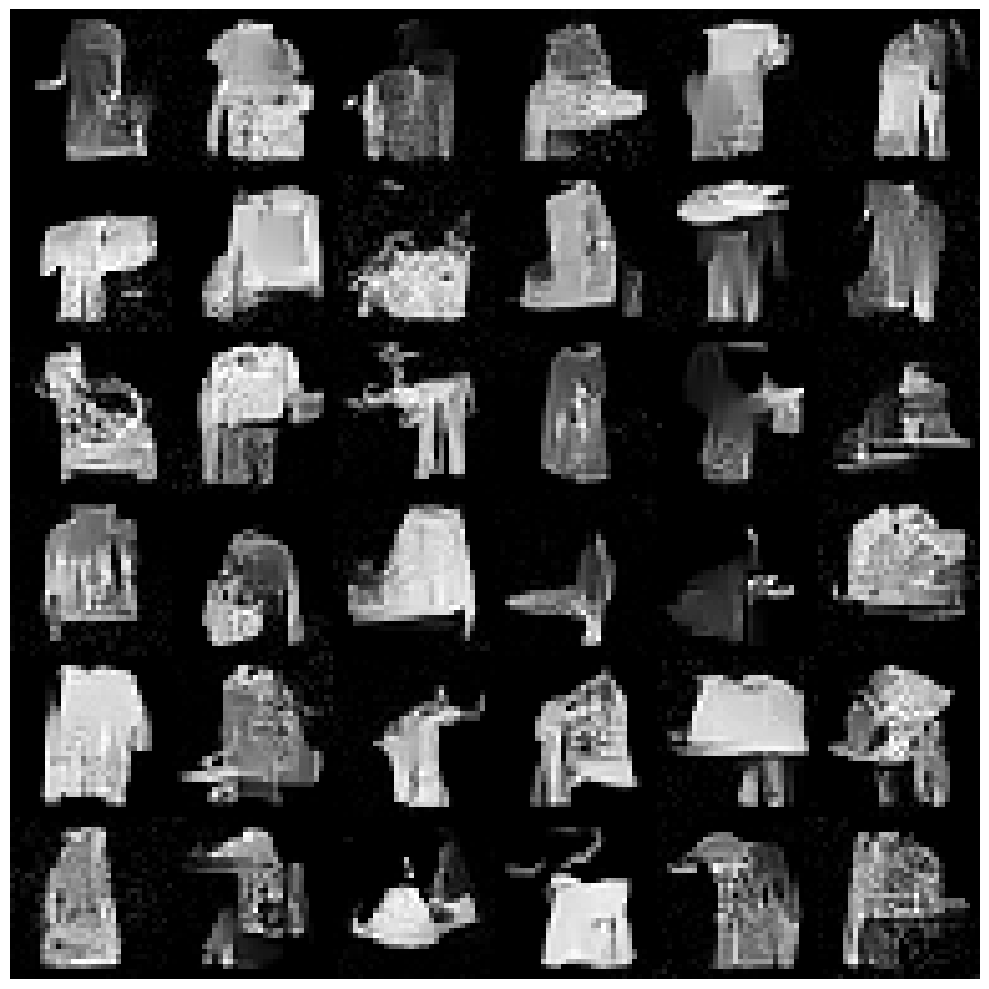

In [32]:
# 这段代码会生成一个 m x m 的图像网格，显示处理后的图像。这些图像通常表示逐步去噪后的结果
fig, ax = plt.subplots(m, m, figsize=(10, 10), gridspec_kw={"wspace": 0, "hspace": 0})
for i in range(m):
  for j in range(m):
    ax[i][j].axis('off')
    ax[i][j].imshow(X[m * i + j], cmap="gray")
plt.tight_layout()

In [ ]:
import matplotlib.animation as animation

random_index = 53
timesteps = 50
fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()


## U-net model

In [ ]:
# 定义model类，此示例假设采用类似 U-Net 的架构，常用于图像处理任务。
# Define some useful functions and U-Net
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# small helper modules

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = 2, p2 = 2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1)
    )

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RandomOrLearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = torch.einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

# model

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        resnet_block_groups = 8,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)
model = Unet(64)

# 4.评估测试 FIDtest

计算 FID 的步骤：
准备真实图像和生成图像： 将真实图像和生成图像准备好，确保它们的格式和维度匹配。

使用 Inception 网络计算特征向量： 使用预训练的 Inception 网络计算真实图像和生成图像的特征向量。PyTorch 中有预训练的 Inception 网络可以使用

In [ ]:
# 1.使用 Inception 网络计算特征向量

inception = models.inception_v3(pretrained=True, transform_input=False, aux_logits=True)
inception.eval()
'''
def get_inception_features(images):
    # Preprocess images
    images = torch.stack([T()(img) for img in images])

    # Compute Inception features
    with torch.no_grad():
        features = inception(images)

    return features

'''
def get_inception_features(images):
    # Create the transformation
    transform = T.Compose([
        T.Resize((299, 299)),  # Resize to InceptionV3 input size
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to InceptionV3 stats
    ])

    # Preprocess images
    images = torch.stack([transform(img) for img in images])

    # Compute Inception features
    with torch.no_grad():
        features = inception(images)

    return features


In [ ]:
# 2.计算 FID： 使用真实图像和生成图像的特征向量计算 FID。
from scipy.linalg import sqrtm
import numpy as np

def calculate_fid(real_images, generated_images):
    features_real = get_inception_features(real_images).numpy()
    features_generated = get_inception_features(generated_images).numpy()

    # Calculate mean and covariance for real and generated features
    mean_real, cov_real = np.mean(features_real, axis=0), np.cov(features_real, rowvar=False)
    mean_generated, cov_generated = np.mean(features_generated, axis=0), np.cov(features_generated, rowvar=False)

    # Calculate FID
    trace = np.trace(cov_real + cov_generated - 2 * sqrtm(cov_real @ cov_generated))
    fid = np.linalg.norm(mean_real - mean_generated) + trace

    return fid


In [ ]:
# 3.比较生成的图像和原始图像： 将原始图像和生成的图像传递给 calculate_fid 函数，然后得到 FID 分数。
real_images = X_denoised  # Original images
generated_images = X  # Generated images

fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid_score}")


In [ ]:
# another one, need to try
pip install clean-fid
from cleanfid import fid
score = fid.compute_fid(fdir1, fdir2) # 1.计算两个图像文件夹之间的 FID

# 2.Compute FID using a generative model and pre-computed dataset statistics
# 2.计算一个图像文件夹和预先计算的数据集统计数据之间的 FID（例如，FFHQ）
from cleanfid import fid
score = fid.compute_fid(fdir1, dataset_name="FFHQ", dataset_res=1024, dataset_split="trainval70k")

# 3.使用生成模型和预先计算的数据集统计数据计算 FID
from cleanfid import fid
# function that accepts a latent and returns an image in range[0,255]
gen = lambda z: GAN(latent=z, ... , <other_flags>)
score = fid.compute_fid(gen=gen, dataset_name="FFHQ",
        dataset_res=256, num_gen=50_000, dataset_split="trainval70k")

# 4.To use the CLIP features when computing the FID [Kynkäänniemi et al, 2022], specify the flag model_name="clip_vit_b_32"
# 4.要在计算 FID 时使用 CLIP 功能[Kynkäänniemi et al, 2022]，请指定标志model_name="clip_vit_b_32"，类似与现有模型比较
from cleanfid import fid
score = fid.compute_fid(fdir1, fdir2, mode="clean", model_name="clip_vit_b_32")

In [ ]:
# 计算KID
# KID 分数可以使用与 FID 类似的界面来计算。KID 的数据集统计信息仅针对较小的数据集AFHQ、BreCaHAD和进行预先计算MetFaces。
# 1.计算两个图像文件夹之间的 KID
from cleanfid import fid
score = fid.compute_kid(fdir1, fdir2)

# 2.计算一个图像文件夹和预先计算的数据集统计数据之间的 KID
from cleanfid import fid
score = fid.compute_kid(fdir1, dataset_name="brecahad", dataset_res=512, dataset_split="train")

# 3.使用生成模型和预先计算的数据集统计数据计算 KID：
from cleanfid import fid
# function that accepts a latent and returns an image in range[0,255]
gen = lambda z: GAN(latent=z, ... , <other_flags>)
score = fid.compute_kid(gen=gen, dataset_name="brecahad", dataset_res=512, num_gen=50_000, dataset_split="train")

# https://github.com/GaParmar/clean-fid